In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.mstats import mquantiles

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error


In [2]:
df = pd.read_csv("C:/1. Yuke/Master 2nd semester/MBAN5110_Predictive Modelling/data_set_hackathon.csv")

df

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route
0,13.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001
1,15.07.2009,24.03.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001
2,16.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001
3,17.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001
4,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001
...,...,...,...,...,...,...,...,...,...,...,...
2415,13.07.2011,15.02.2012,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819196,128.52,EUR,12,FI0003
2416,13.07.2011,15.02.2012,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819201,128.52,EUR,12,FI0003
2417,13.07.2011,15.02.2012,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819206,128.52,EUR,12,FI0003
2418,13.07.2011,15.02.2012,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819210,107.10,EUR,10,FI0003


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB


In [4]:
df.describe()

,Customer Order Code,value
count,2.420000e+03,2420.000000
mean,3.200672e+09,1162.976624
std,1.004408e+05,2560.595118
min,3.200435e+09,-0.030000
25%,3.200614e+09,33.030000
50%,3.200711e+09,70.490000
75%,3.200729e+09,1363.200000
max,3.201062e+09,38937.500000


In [5]:
# Format the cells

df.replace(r'\N', 0, inplace=True)

In [6]:
# look for if there's anything with Value greater than 0 
# remove rows with Value smaller than 0 

negative_rows = df[df['value'] < 0]

negative_rows

df = df[df['value'] >= 0]

In [7]:
df.columns

Index(['order_date', 'requested_delivery_date', 'Customer Country Code',
       'Product Code', 'Description', 'order_type', 'Customer Order Code',
       'value', 'Curr', 'items', 'Route'],
      dtype='object')

In [8]:
# rename column names for easier reference 

df.rename(columns={'order_date': 'Order Date', 'requested_delivery_date': 'Requested Delivery Date', 'order_type': 'Order Type', 'value': 'Value', 'Curr': 'Currency', 'items': 'Items'}, inplace=True)

C:\Users\kryst\AppData\Local\Temp\ipykernel_37044\395502927.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'order_date': 'Order Date', 'requested_delivery_date': 'Requested Delivery Date', 'order_type': 'Order Type', 'value': 'Value', 'Curr': 'Currency', 'items': 'Items'}, inplace=True)


In [9]:
# Tranform data type to date

df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y')
df['Requested Delivery Date'] = pd.to_datetime(df['Requested Delivery Date'], format='%d.%m.%Y')

df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month

df['Delivery Year'] = df['Requested Delivery Date'].dt.year
df['Delivery Month'] = df['Requested Delivery Date'].dt.month

C:\Users\kryst\AppData\Local\Temp\ipykernel_37044\3672491665.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y')
C:\Users\kryst\AppData\Local\Temp\ipykernel_37044\3672491665.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Requested Delivery Date'] = pd.to_datetime(df['Requested Delivery Date'], format='%d.%m.%Y')
C:\Users\kryst\AppData\Local\Temp\ipykernel_37044\3672491665.py:6: SettingWithCopyWarning: 
A value is trying to be se

In [10]:
df.dtypes

Order Date                 datetime64[ns]
Requested Delivery Date    datetime64[ns]
Customer Country Code              object
Product Code                       object
Description                        object
Order Type                         object
Customer Order Code                 int64
Value                             float64
Currency                           object
Items                              object
Route                              object
Order Year                          int32
Order Month                         int32
Delivery Year                       int32
Delivery Month                      int32
dtype: object

In [11]:
# convert Items into type - int 
df['Items'] = df['Items'].astype(int)

C:\Users\kryst\AppData\Local\Temp\ipykernel_37044\1689789886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Items'] = df['Items'].astype(int)


In [12]:
# drop rows that the order date is in 2012 

df = df[~((df['Order Date'] >= '2012-01-01'))]

df

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,Route,Order Year,Order Month,Delivery Year,Delivery Month
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001,2009,7,2010,1
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001,2009,7,2010,3
2,2009-07-16,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001,2009,7,2010,2
3,2009-07-17,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001,2009,7,2010,2
4,2009-07-21,2010-02-01,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001,2009,7,2010,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819186,107.10,EUR,10,FI0003,2011,7,2012,2
2415,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819196,128.52,EUR,12,FI0003,2011,7,2012,2
2416,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819201,128.52,EUR,12,FI0003,2011,7,2012,2
2417,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819206,128.52,EUR,12,FI0003,2011,7,2012,2


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2409 entries, 0 to 2418
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Order Date               2409 non-null   datetime64[ns]
 1   Requested Delivery Date  2409 non-null   datetime64[ns]
 2   Customer Country Code    2409 non-null   object        
 3   Product Code             2409 non-null   object        
 4   Description              2409 non-null   object        
 5   Order Type               2409 non-null   object        
 6   Customer Order Code      2409 non-null   int64         
 7   Value                    2409 non-null   float64       
 8   Currency                 2409 non-null   object        
 9   Items                    2409 non-null   int32         
 10  Route                    2409 non-null   object        
 11  Order Year               2409 non-null   int32         
 12  Order Month              2409 non-null 

#### First Uncertainty: Time series analysis on the number of distinct orders per month 

In [14]:
# Extract year and month for grouping
df['YearMonth'] = df['Order Date'].dt.to_period('M')

df

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,Route,Order Year,Order Month,Delivery Year,Delivery Month,YearMonth
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001,2009,7,2010,1,2009-07
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001,2009,7,2010,3,2009-07
2,2009-07-16,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001,2009,7,2010,2,2009-07
3,2009-07-17,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001,2009,7,2010,2,2009-07
4,2009-07-21,2010-02-01,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001,2009,7,2010,2,2009-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819186,107.10,EUR,10,FI0003,2011,7,2012,2,2011-07
2415,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819196,128.52,EUR,12,FI0003,2011,7,2012,2,2011-07
2416,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819201,128.52,EUR,12,FI0003,2011,7,2012,2,2011-07
2417,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819206,128.52,EUR,12,FI0003,2011,7,2012,2,2011-07


In [15]:
# Group transaction into monthly information -- with distinct order number

monthly_order = df.groupby('YearMonth').agg({'Customer Order Code': 'count'}).reset_index()

monthly_order = monthly_order.sort_values(by='YearMonth')

In [16]:
monthly_order

,YearMonth,Customer Order Code
0,2009-07,109
1,2009-08,14
2,2009-09,18
3,2009-10,5
4,2009-11,2
5,2009-12,42
6,2010-01,39
7,2010-02,55
8,2010-03,78
9,2010-04,17


In [17]:
monthly_order.rename(columns = {"Customer Order Code": "Count of Distinct Order"}, inplace = True)

monthly_order

,YearMonth,Count of Distinct Order
0,2009-07,109
1,2009-08,14
2,2009-09,18
3,2009-10,5
4,2009-11,2
5,2009-12,42
6,2010-01,39
7,2010-02,55
8,2010-03,78
9,2010-04,17


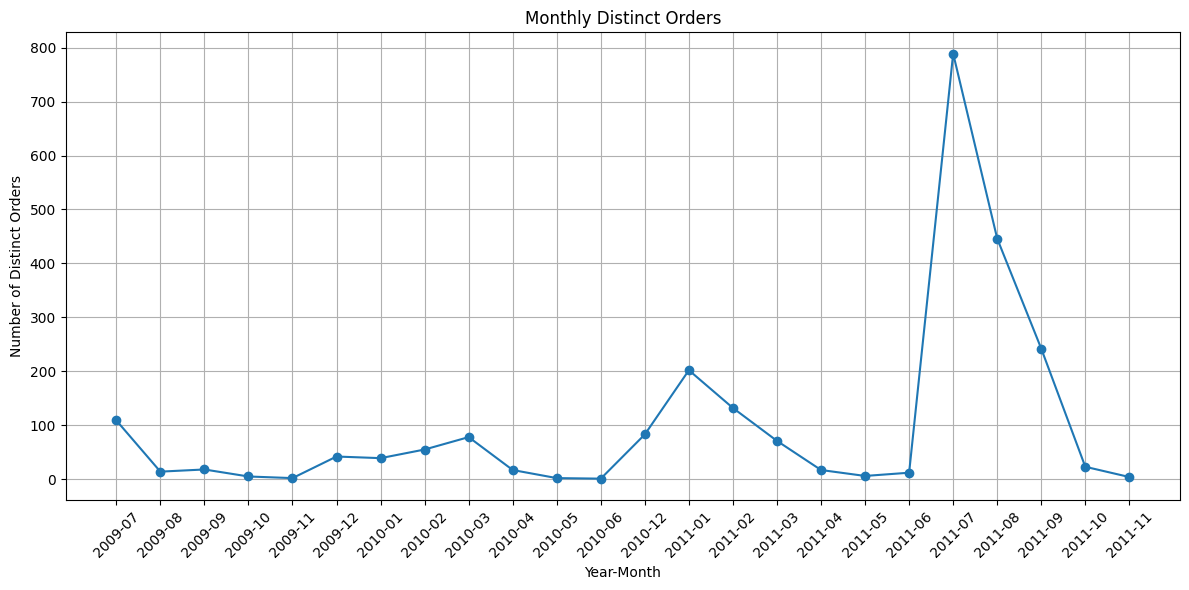

In [18]:
# Convert YearMonth to a string format for plotting
monthly_order.reset_index(inplace=True)
monthly_order['YearMonthStr'] = monthly_order['YearMonth'].dt.strftime('%Y-%m')

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(monthly_order['YearMonthStr'], monthly_order['Count of Distinct Order'], marker='o')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title('Monthly Distinct Orders')
plt.xlabel('Year-Month')
plt.ylabel('Number of Distinct Orders')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
monthly_order = monthly_order.drop(columns = ['index'])

monthly_order

,YearMonth,Count of Distinct Order,YearMonthStr
0,2009-07,109,2009-07
1,2009-08,14,2009-08
2,2009-09,18,2009-09
3,2009-10,5,2009-10
4,2009-11,2,2009-11
5,2009-12,42,2009-12
6,2010-01,39,2010-01
7,2010-02,55,2010-02
8,2010-03,78,2010-03
9,2010-04,17,2010-04


In [20]:
# Perform ADF test on the 'Distinct Orders' series
adf_result = adfuller(monthly_order['Count of Distinct Order'])

# Extract results
adf_stat = adf_result[0]  # Test statistic
p_value = adf_result[1]   # p-value
critical_values = adf_result[4]  # Critical values

# Print the results
print("ADF Statistic:", adf_stat)
print("p-value:", p_value)
print("Critical Values:", critical_values)

# Here, the p-value is much higher than 0.05, indicating that the series is not stationary 
# The time series here exhibits trends, seasonality or other non-stationary behaviours

ADF Statistic: 3.0959042843566085
p-value: 1.0
Critical Values: {'1%': -3.9240193847656246, '5%': -3.0684982031250003, '10%': -2.67389265625}


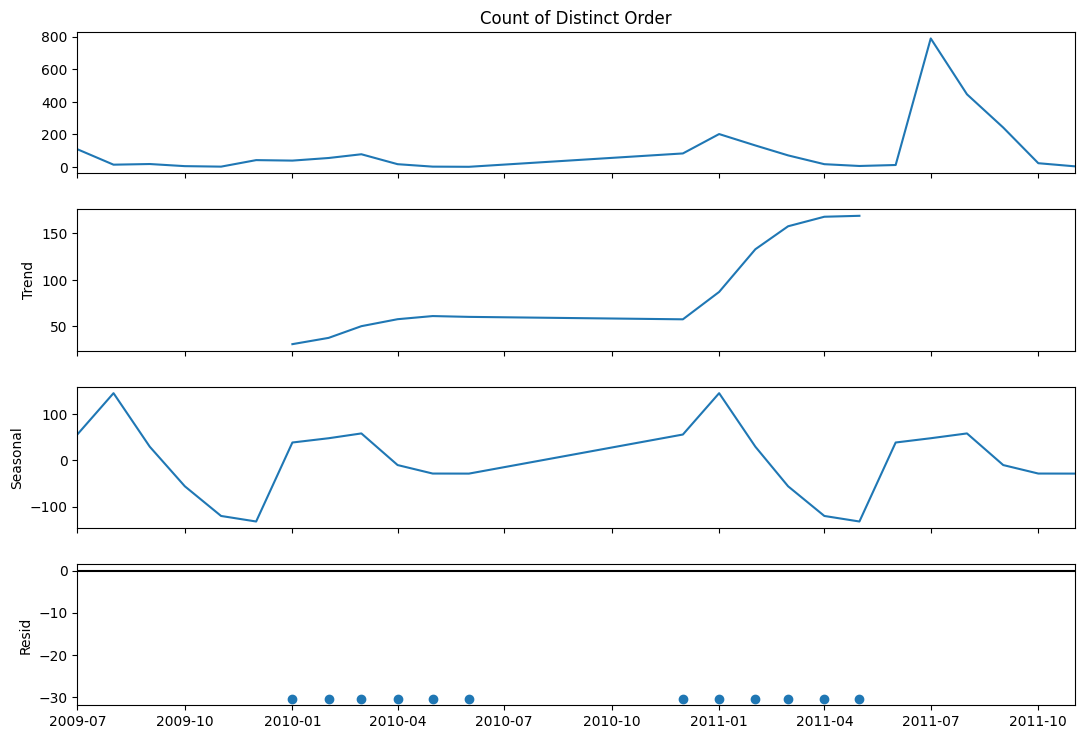

In [21]:
# Time Series Decomposition
# Decompose the time series into trend, seasonality, and residuals
monthly_order['YearMonth'] = monthly_order['YearMonth'].dt.to_timestamp()

# Set 'YearMonth' as the index
monthly_order.set_index('YearMonth', inplace=True)


decomposition = seasonal_decompose(monthly_order['Count of Distinct Order'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()


# showing a clear seasonal pattern with peaks and troughs in the seasonal chart -- a repeating pattern 
# repeating as a trend for 12-17 months 

This time series decomposition breaks down the "Count of Distinct Orders" into three components:

Trend: Shows a general upward movement, peaking mid-period, followed by stabilization or slight decline.
Seasonality: Highlights consistent annual patterns, with regular peaks and troughs reflecting seasonal demand (e.g., holidays or weather-related trends).
Residuals: Captures random variability, with most noise centered around zero, except for a few notable outliers likely due to exceptional events.
Key insights include strong seasonality and an overall growth trend, crucial for demand forecasting, while residuals indicate the randomness to be managed in predictive models.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

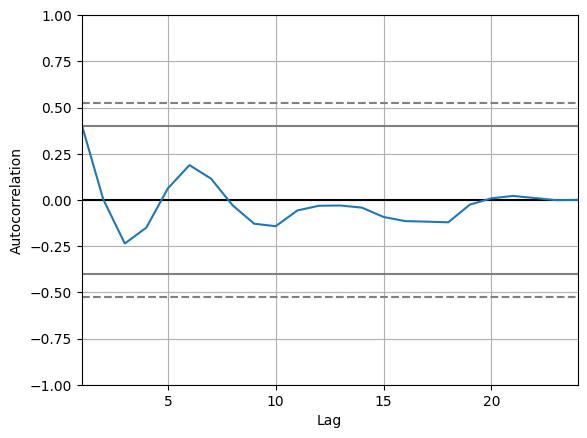

In [22]:
pd.plotting.autocorrelation_plot(monthly_order['Count of Distinct Order'])

# The time series data has a short-term memory, with stronger autocorrelations at lower lags, 
# particularly lag 1.

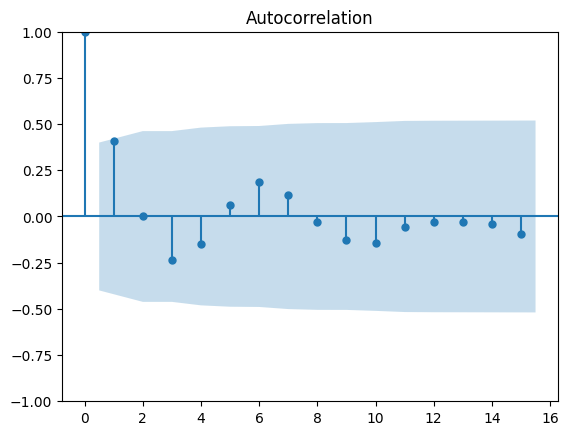

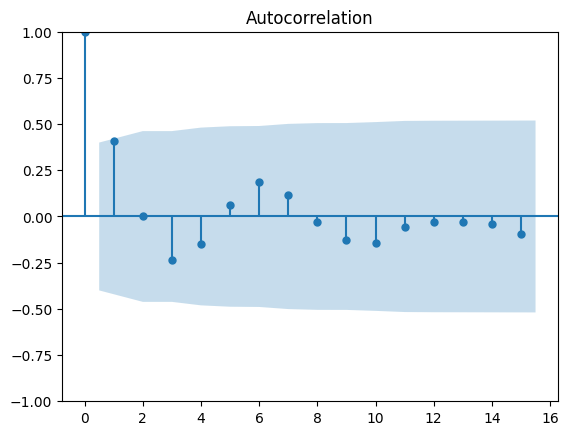

In [23]:
plot_acf(monthly_order['Count of Distinct Order'], lags=15)

The series exhibits significant positive autocorrelation at lag 1 and lag 2, showing that recent values strongly influence current ones. Beyond lag 2, autocorrelation values fall within the confidence interval, indicating no statistically significant relationship at longer lags. The damping pattern suggests that the influence of past values weakens over time, and there is no evidence of strong periodicity or recurring patterns. This behavior supports using forecasting models like SARIMA with short-term lag parameters (e.g., lag 1 or 2), as longer lags do not contribute much predictive power. The series is primarily influenced by short-term dependencies.

In [24]:


# Generate a complete date range from the earliest to the latest date
full_date_range = pd.date_range(start=monthly_order.index.min(), 
                                end=monthly_order.index.max(), 
                                freq='MS')  # Monthly start frequency

# Reindex the DataFrame to the full date range
monthly_order = monthly_order.reindex(full_date_range, fill_value=0)

# Reset index and rename columns for consistency
monthly_order.reset_index(inplace=True)
monthly_order.rename(columns={'index': 'YearMonth'}, inplace=True)

# Display the updated DataFrame
monthly_order

,YearMonth,Count of Distinct Order,YearMonthStr
0,2009-07-01,109,2009-07
1,2009-08-01,14,2009-08
2,2009-09-01,18,2009-09
3,2009-10-01,5,2009-10
4,2009-11-01,2,2009-11
5,2009-12-01,42,2009-12
6,2010-01-01,39,2010-01
7,2010-02-01,55,2010-02
8,2010-03-01,78,2010-03
9,2010-04-01,17,2010-04


In [122]:
# Define the SARIMA model - with seasonality considered

# monthly_order.index = monthly_order.index.to_period('M')


In [35]:
# Set 'YearMonth' as the index
monthly_order.set_index('YearMonth', inplace=True)

sarima_model = SARIMAX(
    monthly_order['Count of Distinct Order'],
    order=(2, 0, 2),  # ARIMA(p, d, q) - suggesting current value depends on previous 2 observations, and is linear trend 
    seasonal_order=(1, 0, 1, 12),  # Seasonal (P, D, Q, s) where s=12 for monthly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False,
)
# Fit the model
sarima_fit = sarima_model.fit(disp=False)


c:\Users\kryst\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kryst\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kryst\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\kryst\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

In [36]:
monthly_order

,Count of Distinct Order,YearMonthStr
YearMonth,,
2009-07-01,109,2009-07
2009-08-01,14,2009-08
2009-09-01,18,2009-09
2009-10-01,5,2009-10
2009-11-01,2,2009-11
2009-12-01,42,2009-12
2010-01-01,39,2010-01
2010-02-01,55,2010-02
2010-03-01,78,2010-03


In [37]:
forecast_5_months = sarima_fit.get_forecast(steps=5)
forecast_5_values = forecast_5_months.predicted_mean
forecast_5_conf_int = forecast_5_months.conf_int()

print(forecast_5_values)

2011-12-01     80.261259
2012-01-01    237.389855
2012-02-01    145.027875
2012-03-01     59.318414
2012-04-01     14.736154
Freq: MS, Name: predicted_mean, dtype: float64


In [38]:
# Forecast for next 2 months

forecast_2_months = sarima_fit.get_forecast(steps=2)
forecast_2_values = forecast_2_months.predicted_mean
forecast_2_conf_int = forecast_2_months.conf_int()

In [39]:
forecast_2_values

2011-12-01     80.261259
2012-01-01    237.389855
Freq: MS, Name: predicted_mean, dtype: float64

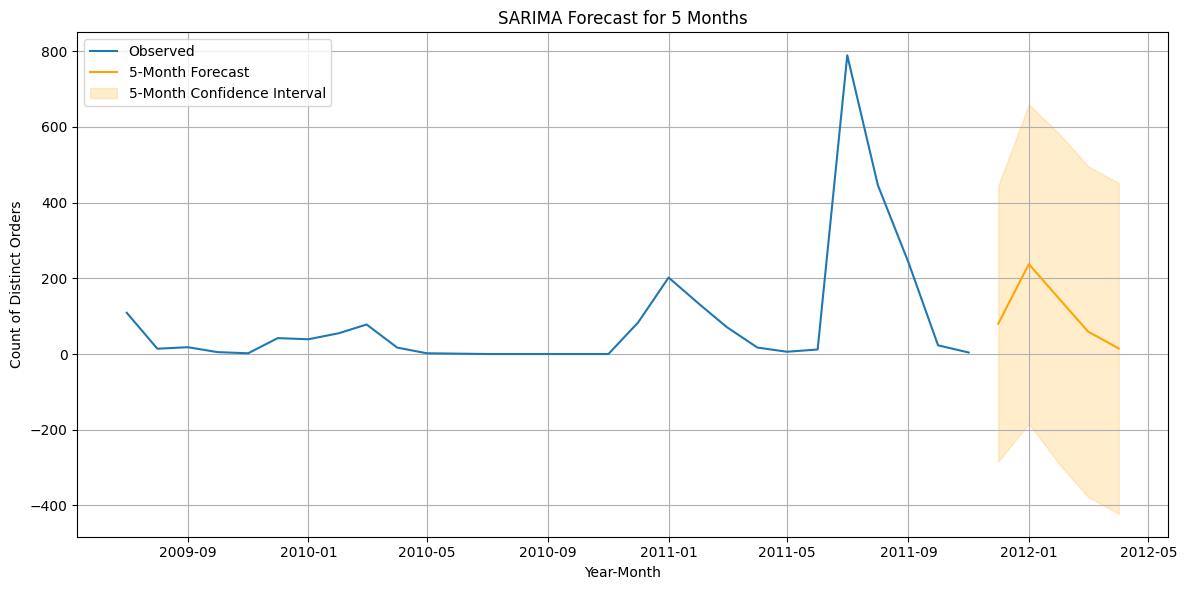

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_order.index, monthly_order['Count of Distinct Order'], label='Observed')
plt.plot(forecast_5_values.index, forecast_5_values, color='orange', label='5-Month Forecast')
plt.fill_between(
    forecast_5_conf_int.index,
    forecast_5_conf_int.iloc[:, 0],
    forecast_5_conf_int.iloc[:, 1],
    color='orange',
    alpha=0.2,
    label='5-Month Confidence Interval',
)
plt.title('SARIMA Forecast for 5 Months')
plt.xlabel('Year-Month')
plt.ylabel('Count of Distinct Orders')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

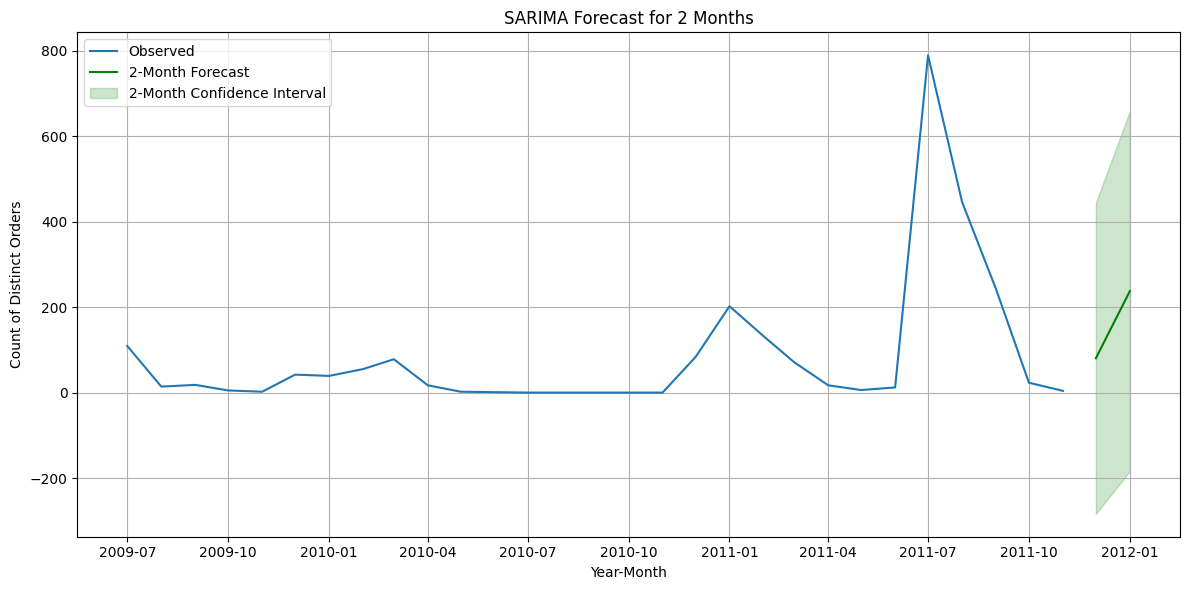

In [42]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(monthly_order.index, monthly_order['Count of Distinct Order'], label='Observed')
plt.plot(forecast_2_values.index, forecast_2_values, color='green', label='2-Month Forecast')
plt.fill_between(
    forecast_2_conf_int.index,
    forecast_2_conf_int.iloc[:, 0],
    forecast_2_conf_int.iloc[:, 1],
    color='green',
    alpha=0.2,
    label='2-Month Confidence Interval',
)

plt.title('SARIMA Forecast for 2 Months')
plt.xlabel('Year-Month')
plt.ylabel('Count of Distinct Orders')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Second Uncertainty: Which product would be demanded 

In [47]:
# Adding Seasonal categorical variable

def month_to_season(month):
    if month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    elif month in [9, 10, 11]:
        return 3  # Fall
    else:
        return 4  # Winter 
    

df["Order Season"] = df['Order Month'].apply(month_to_season)
df['Delivery Season'] = df['Delivery Month'].apply(month_to_season)

In [48]:
df

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,Route,Order Year,Order Month,Delivery Year,Delivery Month,YearMonth,Order Season,Delivery Season
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001,2009,7,2010,1,2009-07,2,4
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001,2009,7,2010,3,2009-07,2,1
2,2009-07-16,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001,2009,7,2010,2,2009-07,2,4
3,2009-07-17,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001,2009,7,2010,2,2009-07,2,4
4,2009-07-21,2010-02-01,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001,2009,7,2010,2,2009-07,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819186,107.10,EUR,10,FI0003,2011,7,2012,2,2011-07,2,4
2415,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819196,128.52,EUR,12,FI0003,2011,7,2012,2,2011-07,2,4
2416,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819201,128.52,EUR,12,FI0003,2011,7,2012,2,2011-07,2,4
2417,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819206,128.52,EUR,12,FI0003,2011,7,2012,2,2011-07,2,4


In [49]:
df['Unit Price'] = df['Value'] / df['Items']

df

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,Route,Order Year,Order Month,Delivery Year,Delivery Month,YearMonth,Order Season,Delivery Season,Unit Price
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001,2009,7,2010,1,2009-07,2,4,389.50
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001,2009,7,2010,3,2009-07,2,1,441.75
2,2009-07-16,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001,2009,7,2010,2,2009-07,2,4,427.50
3,2009-07-17,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001,2009,7,2010,2,2009-07,2,4,451.25
4,2009-07-21,2010-02-01,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001,2009,7,2010,2,2009-07,2,4,441.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819186,107.10,EUR,10,FI0003,2011,7,2012,2,2011-07,2,4,10.71
2415,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819196,128.52,EUR,12,FI0003,2011,7,2012,2,2011-07,2,4,10.71
2416,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819201,128.52,EUR,12,FI0003,2011,7,2012,2,2011-07,2,4,10.71
2417,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819206,128.52,EUR,12,FI0003,2011,7,2012,2,2011-07,2,4,10.71


In [50]:
df.columns

Index(['Order Date', 'Requested Delivery Date', 'Customer Country Code',
       'Product Code', 'Description', 'Order Type', 'Customer Order Code',
       'Value', 'Currency', 'Items', 'Route', 'Order Year', 'Order Month',
       'Delivery Year', 'Delivery Month', 'YearMonth', 'Order Season',
       'Delivery Season', 'Unit Price'],
      dtype='object')

In [54]:
# Features and target
features = ['Customer Country Code', 'Order Type', 'Customer Order Code',
            'Value', 'Items', 'Route', 'Order Year',
            'Delivery Year', 'Order Season', 'Delivery Season', 'Unit Price']
X = df[features]
y = df['Product Code']

# Encode categorical variables using one-hot encoding or label encoding
categorical_columns = ['Customer Country Code', 'Order Type', 'Customer Order Code', 'Route']
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

numerical_columns = ['Value', 'Items', 'Order Year', 'Delivery Year', 'Unit Price']
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train a classification model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)

logloss = log_loss(y_test, probs)
print(f'Log Loss: {logloss:.4f}')

# Convert probabilities into a DataFrame with product codes as columns
probs_df = pd.DataFrame(probs, columns=label_encoder.classes_)

# Add a column to indicate the most likely product for each instance
probs_df['Predicted_Product'] = probs_df.idxmax(axis=1)

# Display the first few rows of the probability DataFrame
probs_df.head()

Log Loss: 9.2245


,L10705000,L10705100,L10705200,L10705300,L10705400,L10705500,L10705600,L10705700,L10850600,L10850700,...,L12918400,L12918500,L12918600,L12918700,L12918800,L12918900,L12919000,L12919100,L12919200,Predicted_Product
0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,...,0.010000,0.02,0.03,0.000000,0.000000,0.000000,0.010000,0.006667,0.003333,L12917900
1,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,...,0.007333,0.00,0.00,0.434357,0.047333,0.000000,0.034667,0.000000,0.006667,L12917700
2,0.0,0.01,0.0,0.0,0.0,0.0,0.02,0.0,0.1565,0.0,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,L10850800
3,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,...,0.030000,0.03,0.04,0.042333,0.107667,0.000000,0.000000,0.000000,0.630000,L12919200
4,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,...,0.005000,0.00,0.00,0.000000,0.015000,0.184167,0.310000,0.000000,0.040000,L12919000


#### Third Uncertainty: What is the quantity demanded for each item in these orders 

In [57]:
# Group the data by 'Product Code' and calculate quantiles for 'Items' (quantity demanded)
grouped_quantiles = df.groupby('Product Code')['Items'].apply(
    lambda x: mquantiles(x, prob=[0.25, 0.5, 0.75])
)

# Convert the result to a DataFrame for better readability
quantiles_per_product = grouped_quantiles.apply(pd.Series)
quantiles_per_product.columns = ['25th Percentile', 'Median', '75th Percentile']

# Display the results
print(quantiles_per_product)

              25th Percentile  Median  75th Percentile
Product Code                                          
L10705000                4.70     6.0             8.00
L10705100                6.00     9.0            13.05
L10705200                5.00     6.0            10.00
L10705300                5.00     7.0            10.00
L10705400                0.00     7.0            12.10
L10705500                5.00     8.5            13.10
L10705600                5.00     7.5             8.00
L10705700                3.95     6.5             8.25
L10850600                3.00     5.0            10.00
L10850700                1.00     2.0             5.05
L10850800                2.00     3.5             6.00
L10850900                3.95     5.0            11.00
L10852800                1.70     4.0             8.00
L10852900                1.00     3.0             4.00
L10853100                4.40     6.0             6.00
L12134400                3.00     6.0            10.80
L12134500 

In [59]:
# Group by 'Product Code' and 'Items' to calculate frequency
quantity_data = df.groupby(['Product Code', 'Items']).size().reset_index(name='Frequency')

# Calculate probabilities and cumulative probabilities for each Product Code
quantity_data['Probability'] = quantity_data.groupby('Product Code')['Frequency'].transform(lambda x: x / x.sum())
quantity_data['Cumulative Probability'] = quantity_data.groupby('Product Code')['Probability'].cumsum()

# Define intervals for random numbers
quantity_data['Interval of Random Numbers'] = (
    quantity_data.groupby('Product Code')['Cumulative Probability']
    .shift(fill_value=0).round(2).astype(str) +
    " through " +
    quantity_data['Cumulative Probability'].round(2).astype(str)
)

# Display the result using a simple print statement
print(quantity_data)

# Alternatively, save the result to a CSV file
quantity_data.to_csv("quantity_demanded_probabilities.csv", index=False)

    Product Code  Items  Frequency  Probability  Cumulative Probability  \
0      L10705000      0          2     0.080000                0.080000   
1      L10705000      1          1     0.040000                0.120000   
2      L10705000      2          2     0.080000                0.200000   
3      L10705000      4          1     0.040000                0.240000   
4      L10705000      5          6     0.240000                0.480000   
..           ...    ...        ...          ...                     ...   
553    L12919200     20          1     0.007874                0.968504   
554    L12919200     22          1     0.007874                0.976378   
555    L12919200     36          1     0.007874                0.984252   
556    L12919200     55          1     0.007874                0.992126   
557    L12919200    385          1     0.007874                1.000000   

    Interval of Random Numbers  
0             0.0 through 0.08  
1            0.08 through 0.12  


#### Fourth Uncertainty: What is the demand lead time of these orders (ie., time elapsed from the instant when an order is received until its delivery)

In [60]:
# Calculate lead time as the difference in days
df['Lead Time (days)'] = (df['Requested Delivery Date'] - df['Order Date']).dt.days

# Display the updated DataFrame with the new 'Lead Time (days)' column
print(df.head())

  Order Date Requested Delivery Date Customer Country Code Product Code  \
0 2009-07-13              2010-01-28                    RU    L10705000   
1 2009-07-15              2010-03-24                    RU    L10705000   
2 2009-07-16              2010-02-04                    RU    L10705000   
3 2009-07-17              2010-02-04                    RU    L10705000   
4 2009-07-21              2010-02-01                    RU    L10705000   

                   Description Order Type  Customer Order Code     Value  \
0  Parka Outdoor Lifestyle STD         VO           3200435553   2337.00   
1  Parka Outdoor Lifestyle STD         VO           3200435694  10160.25   
2  Parka Outdoor Lifestyle STD         VO           3200435741   2992.50   
3  Parka Outdoor Lifestyle STD         VO           3200435907   4061.25   
4  Parka Outdoor Lifestyle STD         VO           3200435963   2208.75   

  Currency  Items   Route  Order Year  Order Month  Delivery Year  \
0      RUB      6  RU00

In [61]:
# Group the data by 'Customer Order Code' and calculate quantiles for 'Lead Time (days)'
grouped_lead_time_quantiles = df.groupby('Product Code')['Lead Time (days)'].apply(
    lambda x: mquantiles(x, prob=[0.25, 0.5, 0.75])
)

# Convert the result to a DataFrame for better readability
quantiles_per_order = grouped_lead_time_quantiles.apply(pd.Series)
quantiles_per_order.columns = ['25th Percentile', 'Median', '75th Percentile']

# Display the results
print(quantiles_per_order)

              25th Percentile  Median  75th Percentile
Product Code                                          
L10705000              181.70   195.0           203.60
L10705100              190.85   200.0           206.40
L10705200              191.00   195.0           202.10
L10705300              192.00   198.0           203.90
L10705400              189.35   199.0           203.55
L10705500              188.00   192.0           196.00
L10705600              189.35   197.5           203.55
L10705700              187.85   191.5           204.30
L10850600              177.95   211.5           231.30
L10850700              172.85   214.0           224.20
L10850800              166.95   187.5           218.10
L10850900              216.95   240.0           258.20
L10852800              188.00   225.0           237.00
L10852900              172.70   201.0           230.05
L10853100              239.80   260.0           299.50
L12134400              167.00   221.0           267.80
L12134500 

In [44]:
# Group by lead time and calculate frequencies
lead_time_data = df['Lead Time (days)'].value_counts().reset_index()
lead_time_data.columns = ['Reorder Lead Time', 'Frequency']
lead_time_data = lead_time_data.sort_values(by='Reorder Lead Time').reset_index(drop=True)

# Calculate probabilities and cumulative probabilities
lead_time_data['Probability'] = lead_time_data['Frequency'] / lead_time_data['Frequency'].sum()
lead_time_data['Cumulative Probability'] = lead_time_data['Probability'].cumsum()

# Define intervals for random numbers
lead_time_data['Interval of Random Numbers'] = (
    lead_time_data['Cumulative Probability'].shift(fill_value=0).round(2).astype(str) +
    " through " +
    lead_time_data['Cumulative Probability'].round(2).astype(str)
)

# Display the resulting table
print(lead_time_data)

      Reorder Lead Time  Frequency  Probability  Cumulative Probability  \
0                 -1056          1     0.000413                0.000413   
1                 -1037          1     0.000413                0.000826   
2                 -1011          1     0.000413                0.001239   
3                 -1000          1     0.000413                0.001652   
4                  -997          1     0.000413                0.002065   
...                 ...        ...          ...                     ...   
1300               1021          1     0.000413                0.998348   
1301               1029          1     0.000413                0.998761   
1302               1040          1     0.000413                0.999174   
1303               1045          1     0.000413                0.999587   
1304               1054          1     0.000413                1.000000   

     Interval of Random Numbers  
0               0.0 through 0.0  
1               0.0 through 0.0

#### Monte Carlo Simulation

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 1: Prepare Data
# Assume `monthly_order` is the DataFrame for the first uncertainty
# Split data into training and testing
train_size = int(len(monthly_order) * 0.8)
train_data = monthly_order['Count of Distinct Order'][:train_size]
test_data = monthly_order['Count of Distinct Order'][train_size:]

# Step 2: SARIMA Model for Distinct Orders
sarima_model = SARIMAX(
    train_data,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_fit = sarima_model.fit(disp=False)
distinct_orders_forecast = sarima_fit.get_forecast(steps=len(test_data) + 2)
distinct_orders_mean = distinct_orders_forecast.predicted_mean

# Step 3: Product Selection Probabilities (from classification model)
product_probs = probs_df.iloc[:, :-1].to_dict(orient='list')  # Assume `probs_df` contains product probabilities

# Step 4: Quantity Demanded Distribution (from quantile analysis)
quantity_probabilities = quantity_data[['Items', 'Probability', 'Cumulative Probability']]

# Step 5: Lead Time Distribution (from lead time analysis)
lead_time_probabilities = lead_time_data[['Reorder Lead Time', 'Probability', 'Cumulative Probability']]

# Step 6: Monte Carlo Simulation
num_simulations = 1000
simulation_results = []

for _ in range(num_simulations):
    simulated_demand = {'Advance Demand': 0, 'Urgent Demand': 0}
    
    for month_orders in distinct_orders_mean:
        # Simulate distinct orders for the month
        num_orders = int(np.random.poisson(month_orders))
        
        for _ in range(num_orders):
            # Simulate product selection
            product = np.random.choice(list(product_probs.keys()), p=list(product_probs.values()))
            
            # Simulate quantity demanded
            quantity = np.random.choice(
                quantity_probabilities['Items'], 
                p=quantity_probabilities['Probability']
            )
            
            # Simulate lead time
            lead_time = np.random.choice(
                lead_time_probabilities['Reorder Lead Time'], 
                p=lead_time_probabilities['Probability']
            )
            
            # Categorize demand
            if lead_time > 2:
                simulated_demand['Advance Demand'] += quantity
            else:
                simulated_demand['Urgent Demand'] += quantity
    
    simulation_results.append(simulated_demand)

# Convert results to DataFrame
simulation_df = pd.DataFrame(simulation_results)

# Step 7: Evaluate Results
actual_advance_demand = test_data[test_data.index <= '2012-01'].sum()
simulated_advance_demand_mean = simulation_df['Advance Demand'].mean()
mape_advance = mean_absolute_percentage_error([actual_advance_demand], [simulated_advance_demand_mean])

print(f"MAPE (Advance Demand): {mape_advance:.2%}")

# Step 8: Display Simulation Results
import ace_tools as tools; tools.display_dataframe_to_user(name="Monte Carlo Simulation Results", dataframe=simulation_df)


c:\Users\kryst\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kryst\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kryst\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\kryst\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /

ValueError: 'p' must be 1-dimensional

In [ ]:
def mc_simulation(order_quantity, lead_time_data):
    """
    Performs monte-carlo simulation to show effects of uncertainty in demand
    and leadtime on sales and lost sales.
    """

    # initialize a few parameters
    # starting_inv = 8
    epochs = 10
    days = 1000

    # demand parameters for sampling
    demand_values = np.arange(1, 6)
    demand_probs = [0.2, 0.2, 0.2, 0.2, 0.2]

    # leadtime parameters for sampling
    # leadtime_values = np.arange(1, 7)
    leadtime_probs = [0.2, 0.13, 0.1, 0.23, 0.17, 0.17]

    # create summary matrix for storing results of simulation
    summary = pd.DataFrame(data=np.zeros((epochs, 4)),
                           columns=['units_sold',
                                    'units_lost',
                                    'inventory_summary',
                                    'demand_summary'])

    # loop for each epoch
    for i in range(epochs):

        # create matix to track each epoch
        epoch = pd.DataFrame(data=np.zeros((days+max(leadtime_values), 7)),
                             columns=['oh_beginning',
                                      'oh_ending',
                                      'demand',
                                      'sold',
                                      'lost',
                                      'received',
                                      'inv_position'])

        # set starting inventory
        epoch.iloc[0]['oh_beginning'] = starting_inv
        epoch.iloc[0]['inv_position'] = starting_inv

        # loop for each day
        for j in range(days):

            # generate some demand
            epoch.iloc[j]['demand'] = np.random.choice(a=demand_values,
                                                       p=demand_probs)

            # calculate sales
            epoch.iloc[j]['sold'] = min(epoch.iloc[j]['oh_beginning'],
                                        epoch.iloc[j]['demand'])

            # calculate lost sales
            epoch.iloc[j]['lost'] = epoch.iloc[j]['demand'] - epoch.iloc[j]['sold']

            # calculate ending inventory
            epoch.iloc[j]['oh_ending'] = epoch.iloc[j]['oh_beginning'] - epoch.iloc[j]['sold']

            # adjust inventory position
            epoch.iloc[j]['inv_position'] -= epoch.iloc[j]['sold']

'''
            # place an order if necessary
            if epoch.iloc[j]['inv_position'] <= re_order_point:

                # generate a leadtime value
                lead_time = np.random.choice(a=leadtime_values,
                                             p=leadtime_probs)

                # add order to future inventory receipts
                epoch.iloc[j+lead_time]['received'] = order_quantity

                # adjust inventory position
                epoch.iloc[j+1]['inv_position'] = epoch.iloc[j]['inv_position'] + order_quantity
            
            else:
                # roll over inventory position
                epoch.iloc[j+1]['inv_position'] = epoch.iloc[j]['inv_position']

            # add any receipts to inventory for tomorrow
            epoch.iloc[j+1]['oh_beginning'] = (epoch.iloc[j]['oh_ending'] +
                                               epoch.iloc[j+1]['received'])
'''

        # summarize epoch
        summary.iloc[i]['demand_summary'] = epoch['demand'].mean()
        summary.iloc[i]['units_sold'] = epoch['sold'].mean()
        summary.iloc[i]['units_lost'] = epoch['lost'].mean()
        summary.iloc[i]['inventory_summary'] = ((epoch['oh_beginning'] +
                                                epoch['oh_ending'])/2).mean()

    # calculate summary statistics
    sold = np.quantile(summary['units_sold'], q=[0.025, 0.5, 0.975])
    lost = np.quantile(summary['units_lost'], q=[0.025, 0.5, 0.975])
    demand = np.quantile(summary['demand_summary'], q=[0.025, 0.5, 0.975])
    inventory = np.quantile(summary['inventory_summary'], q=[0.025, 0.5, 0.975])

    # add statistics to results
    result = pd.DataFrame(data=[sold, lost, demand, inventory],
                          columns=['Lower Bound', 'Expected Value', 'Upper Bound'],
                          index=['Units sold', 'Units lost', 'Demand', 'Inventory'])

    # reset index to it shows up in Dash
    result = result.reset_index().rename({'index': 'Confidence Intervals'}, axis=1)

    return result.round(2)